In [161]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [162]:
#import data
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

df = pd.read_csv(r"I:\VNL data\Data\Alldata.csv")
df = df.interpolate(method='quadratic')
date_time = pd.to_datetime(df.pop('datetime'), format='%m/%d/%Y %H:%M')
df['Wind'] = df.pop('Wind1')/3.8
print(df.head())

   temp  WinDir  GHI      Wind
0  26.0    60.0  0.0  7.289474
1  26.0    50.0  0.0  7.026316
2  26.0    60.0  0.0  6.815789
3  26.0    50.0  0.0  7.763158
4  25.8    57.0  0.0  7.710526


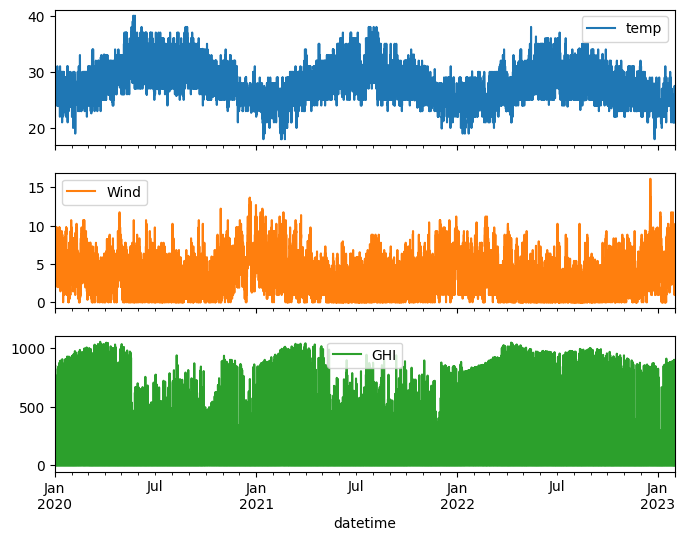

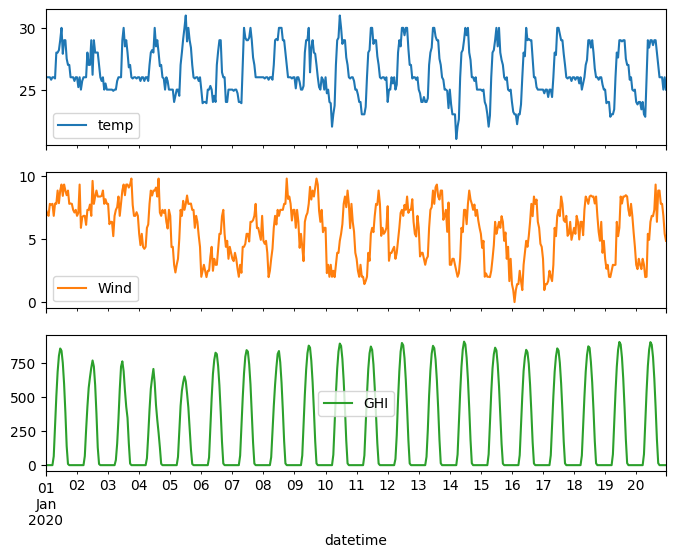

          count        mean         std        min        25%         50%  \
temp    27048.0   27.631100    3.134995  18.000000  25.000000   27.000000   
WinDir  27048.0  162.833481  124.204883   0.000000  49.000000  130.000000   
GHI     27048.0  218.547071  297.491920  -0.048995   0.000000    9.000000   
Wind    27048.0    3.494264    2.481177   0.000000   1.421053    2.947368   

               75%          max  
temp     30.000000    40.000000  
WinDir  300.000000   360.000000  
GHI     411.000000  1054.500000  
Wind      5.184211    16.105263  


In [163]:
#data visualization 
plot_cols = ['temp', 'Wind', 'GHI']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)
plt.show()


print(df.describe().transpose().head())

[    0     1     2 ... 13522 13523 13524] [0.00000000e+00 3.24092635e-01 6.48185271e-01 ... 4.38238061e+03
 4.38270471e+03 4.38302880e+03]


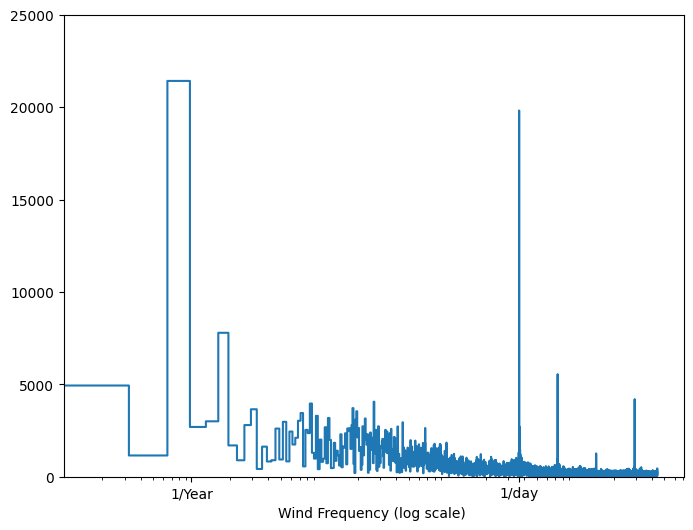

In [164]:
#fourier analysis
fft = tf.signal.rfft(df['Wind'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['GHI'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
print(f_per_dataset,f_per_year)
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 25000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Wind Frequency (log scale) ')
plt.show()

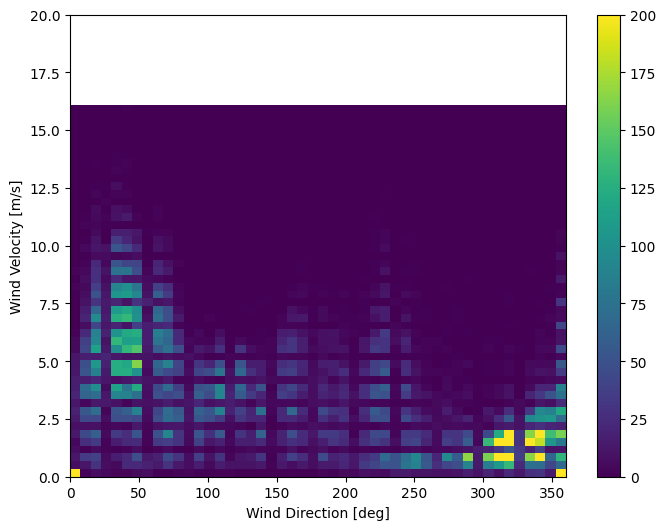

In [165]:
#Wind 2d histogram
plt.hist2d(df['WinDir'], df['Wind'], bins=(48, 48), vmax=200)
plt.colorbar()
plt.ylim([0,20])
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

plt.show()

In [166]:
speed = df['Wind']
Dir = df['WinDir']*np.pi/180 #in radians


(-9.148345705613405,
 12.809494146502647,
 -9.353805831768573,
 10.352263608635845)

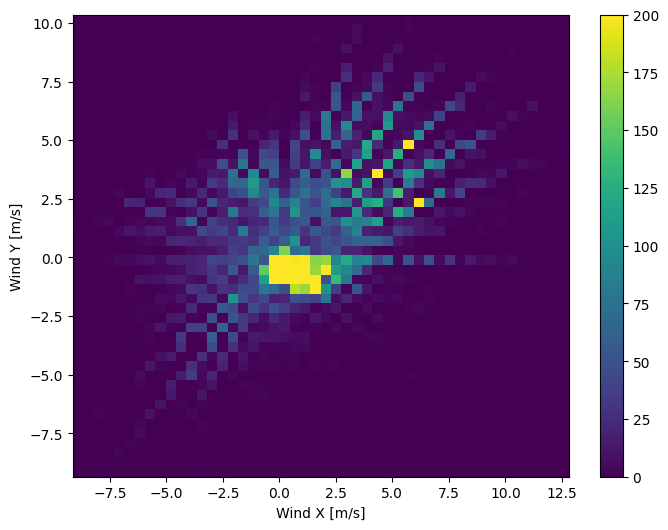

In [167]:
#create Wind vector

df['Vx'] = speed*np.cos(Dir)
df['Vy'] = speed*np.sin(Dir)

plt.hist2d(df['Vx'], df['Vy'], bins=(48, 48), vmax=200)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
plt.savefig('I:\VNL data\image\data analysis\windrose.eps', format='eps', dpi=900)
ax = plt.gca()
ax.axis('tight')

In [168]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))



In [169]:
#split data, last month for test
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.8)]
val_df = df[int(n*0.8):(n-744)]
test_df = df[(n-744):]

num_features = df.shape[1]

In [170]:
train_df.mean()
train_df.std()

temp          3.162485
WinDir      122.907778
GHI         294.061072
Wind          2.481218
Vx            2.964833
Vy            2.585211
Day cos       0.707154
Day sin       0.707093
Year cos      0.702592
Year sin      0.699960
dtype: float64

In [171]:
#normalize data
train_mean = train_df.mean()
train_std = train_df.std()
cursor_mean = train_mean
cursor_std = train_std
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std




In [172]:
train_df

,temp,WinDir,GHI,Wind,Vx,Vy,Day cos,Day sin,Year cos,Year sin
0,-0.565985,-0.813284,-0.738762,1.504702,0.788020,1.950124,1.414183,-0.000480,1.404770,-0.185449
1,-0.565985,-0.894646,-0.738762,1.398643,1.082030,1.590231,1.365998,0.365553,1.404772,-0.184425
2,-0.565985,-0.813284,-0.738762,1.313795,0.708136,1.791443,1.224727,0.706641,1.404773,-0.183401
3,-0.565985,-0.894646,-0.738762,1.695610,1.241781,1.808571,0.999997,0.999541,1.404773,-0.182377
4,-0.629227,-0.837693,-0.738762,1.674398,0.975119,2.009586,0.707123,1.224290,1.404773,-0.181353
...,...,...,...,...,...,...,...,...,...,...
21633,1.647464,0.228147,1.390048,-1.242251,-0.599516,-0.517293,-0.999871,0.999541,-1.412327,0.106996
21634,1.394498,-0.618016,1.974960,-0.255893,-0.338318,0.631926,-1.224601,0.706641,-1.412533,0.105993
21635,1.963671,-0.487837,2.372837,-0.245287,-0.613928,0.630975,-1.365872,0.365553,-1.412739,0.104990
21636,1.963671,-0.569199,2.549671,0.327437,-0.441303,1.197981,-1.414057,-0.000480,-1.412944,0.103987


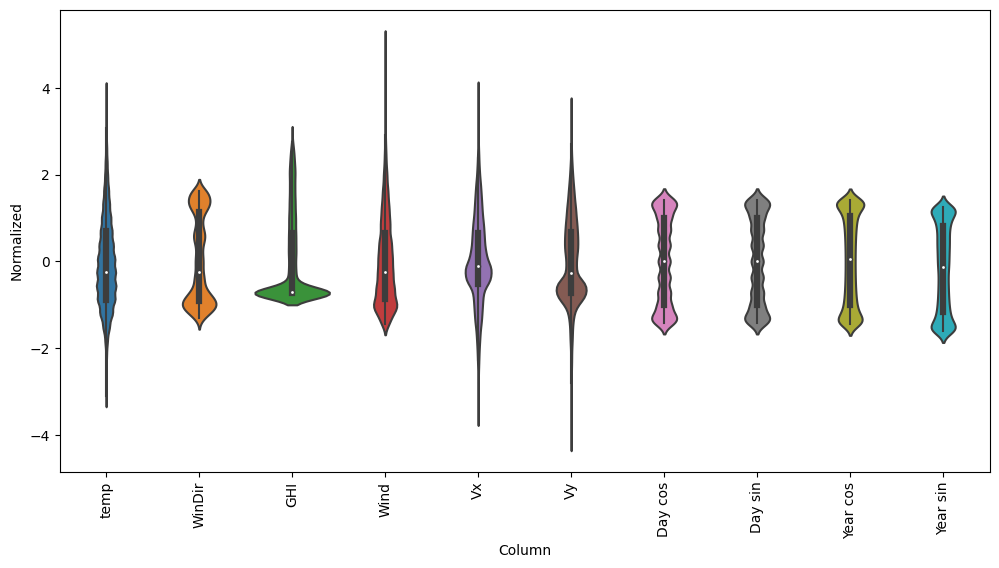

In [173]:
#plot
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)


plt.show()


In [174]:
df.pop('Vx')
df.pop('Vy')

0        6.312869
1        5.382470
2        5.902647
3        5.946924
4        6.466591
           ...   
27043    0.648038
27044    4.495471
27045    3.112445
27046    0.933111
27047    2.983542
Name: Vy, Length: 27048, dtype: float64

In [175]:
#data Windowing
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


In [176]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [177]:
def plot(self, model=None, plot_col='GHI', max_subplots=5):
  inputs, labels = self.example
  plt.figure(figsize=(20, 10))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)
    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index
    print(inputs[n, :, plot_col_index])
    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
      print(predictions[n, :, label_col_index])

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [178]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [179]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [180]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['GHI'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['GHI']

In [181]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 10)
Labels shape (batch, time, features): (32, 1, 1)


In [182]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [183]:
baseline = Baseline(label_index=column_indices['GHI'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

146/146 [==============================] - 0s 606us/step - loss: 0.1561 - mean_absolute_error: 0.2448


In [184]:
wide_window = WindowGenerator(
    input_width=72, label_width=72, shift=1,
    label_columns=['GHI'])

wide_window

Total window size: 73
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
Label column name(s): ['GHI']

Input shape: (32, 72, 10)
Output shape: (32, 72, 1)
tf.Tensor(
[-0.7387617  -0.7387617  -0.7387617  -0.6945532  -0.11848241  0.69631433
  1.4539801   2.0820808   2.4867587   2.644209    2.6051016   2.2742178
  1.7522174   1.0295784   0.22838432 -0.4990156  -0.7387617  -0.7387617
 -0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7387617
 -0.7387617  -0.7387617  -0.7387617  -0.71121645 -0.4065178   0.09847932
  0.61639893  1.0210768   1.3196542   1.4505794   1.4981886   1.3815461
  0.9972722   0.50451744 -0.07597423 -0.57553035 -0.7387617  -0.7387617
 -0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7387617
 -0.7387617  -0.7387617  -0.7387617  -0.70917606 -0.32558224  0.3089798
  1.0397804   1.7277327   2.2667365   2.5292668   2.3558335   1.9759805
  1.5406967   0.91531646  0.19063705 -0.51159805 -0.7387617  -0.7387617
 -0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7387617 ], shape=(72,), dtype=float32)
tf.Tensor(
[-0.7387617  -0.7387617  -0.7

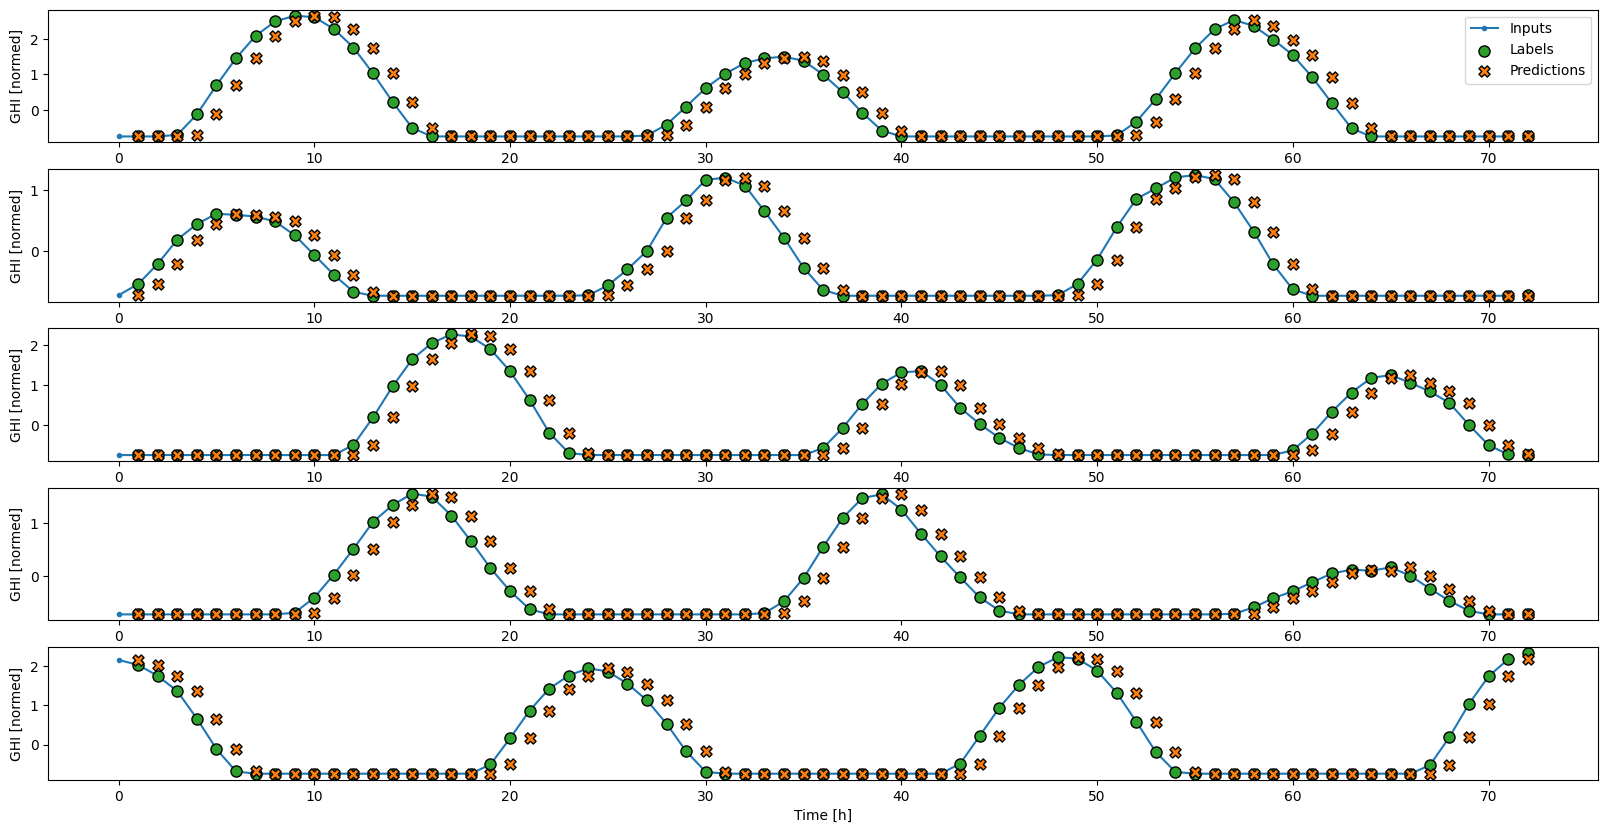

In [185]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

wide_window.plot(baseline)


In [186]:
#Linear model
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 10)
Output shape: (32, 1, 1)


In [187]:
MAX_EPOCHS =200

def compile_and_fit(model, window, patience=30):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='auto')

  model.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate= 0.0001),
                metrics=[tf.keras.metrics.MeanSquaredError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS, batch_size = 64,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [188]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/200
677/677 [==============================] - 1s 935us/step - loss: 1.1885 - mean_squared_error: 2.0698 - val_loss: 0.8952 - val_mean_squared_error: 1.2173
Epoch 2/200
677/677 [==============================] - 1s 825us/step - loss: 0.9759 - mean_squared_error: 1.4143 - val_loss: 0.7166 - val_mean_squared_error: 0.7996
Epoch 3/200
677/677 [==============================] - 1s 818us/step - loss: 0.7857 - mean_squared_error: 0.9300 - val_loss: 0.5680 - val_mean_squared_error: 0.5141
Epoch 4/200
677/677 [==============================] - 1s 817us/step - loss: 0.6265 - mean_squared_error: 0.5985 - val_loss: 0.4551 - val_mean_squared_error: 0.3369
Epoch 5/200
677/677 [==============================] - 1s 811us/step - loss: 0.5025 - mean_squared_error: 0.3869 - val_loss: 0.3762 - val_mean_squared_error: 0.2340
Epoch 6/200
677/677 [==============================] - 1s 816us/step - loss: 0.4095 - mean_squared_error: 0.2570 - val_loss: 0.3303 - val_mean_squared_error: 0.1777
Epoch 7/20

tf.Tensor(
[-0.7387617  -0.7387617  -0.7387617  -0.6945532  -0.11848241  0.69631433
  1.4539801   2.0820808   2.4867587   2.644209    2.6051016   2.2742178
  1.7522174   1.0295784   0.22838432 -0.4990156  -0.7387617  -0.7387617
 -0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7387617
 -0.7387617  -0.7387617  -0.7387617  -0.71121645 -0.4065178   0.09847932
  0.61639893  1.0210768   1.3196542   1.4505794   1.4981886   1.3815461
  0.9972722   0.50451744 -0.07597423 -0.57553035 -0.7387617  -0.7387617
 -0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7387617
 -0.7387617  -0.7387617  -0.7387617  -0.70917606 -0.32558224  0.3089798
  1.0397804   1.7277327   2.2667365   2.5292668   2.3558335   1.9759805
  1.5406967   0.91531646  0.19063705 -0.51159805 -0.7387617  -0.7387617
 -0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7387617 ], shape=(72,), dtype=float32)
tf.Tensor(
[-0.63763803 -0.5582635  -0.5213995  -0.44173646  0.12138327  0.88612944
  1.5252

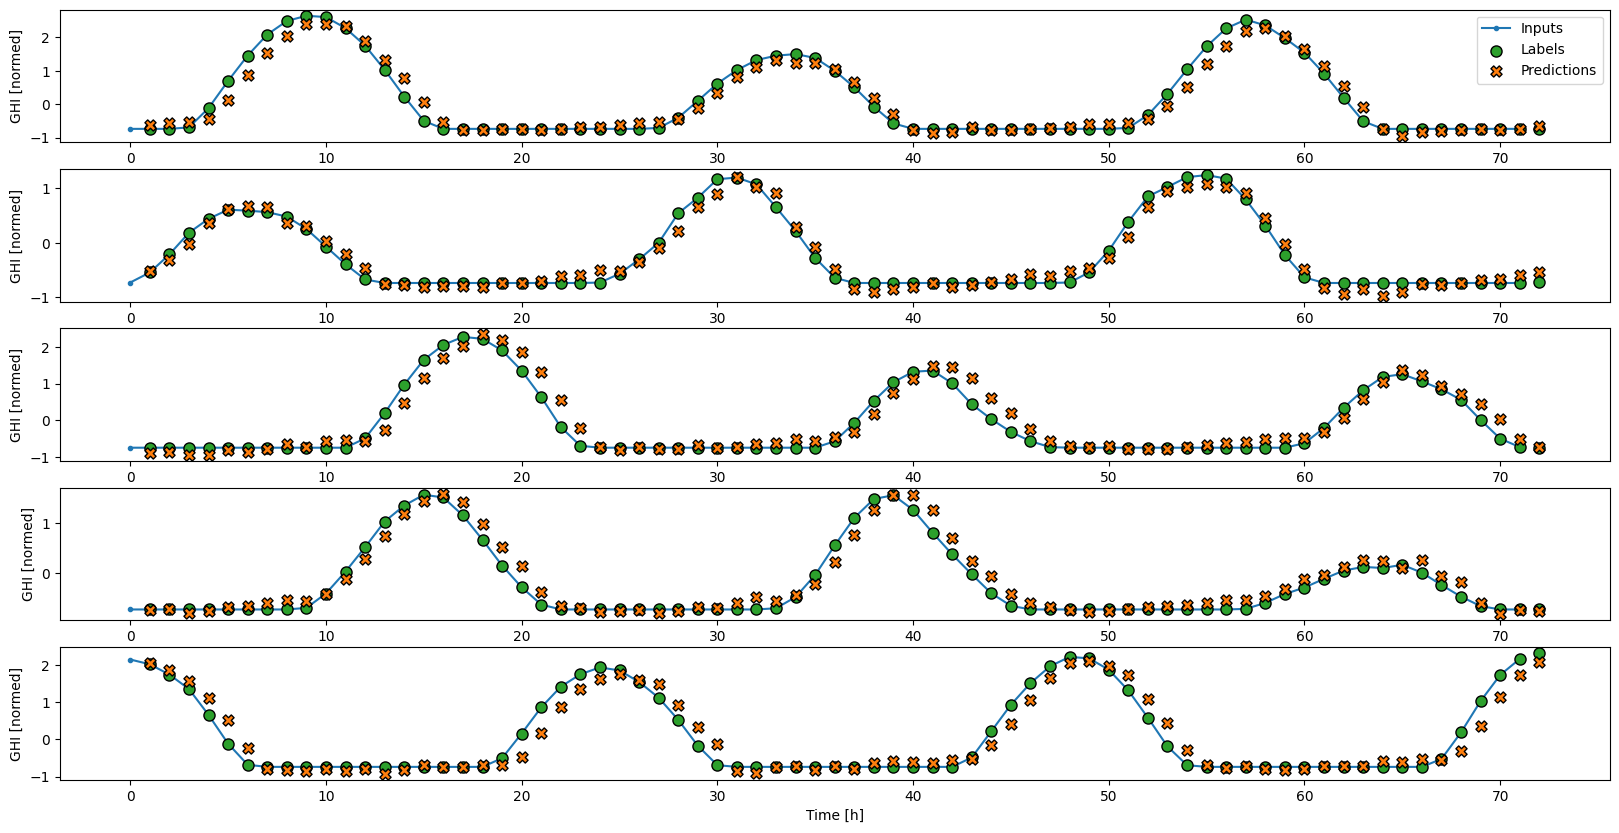

In [189]:
#linear prediction. Mean abosolute error = 0.0919
wide_window.plot(linear)

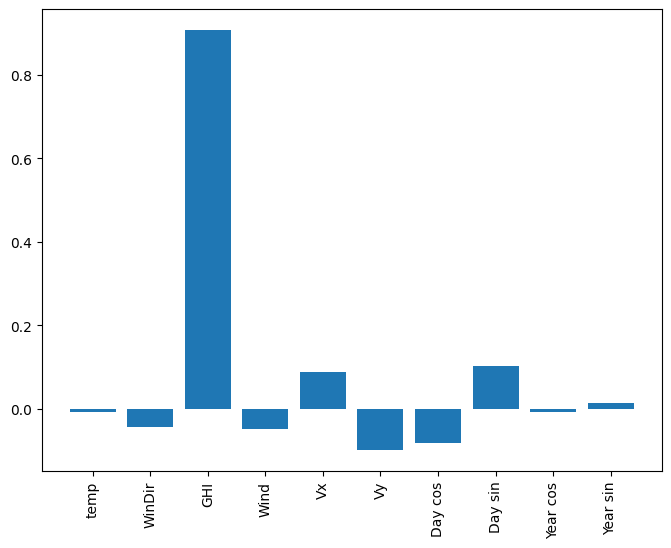

In [190]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [191]:
#dense
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/200
677/677 [==============================] - 1s 1ms/step - loss: 0.2306 - mean_squared_error: 0.1480 - val_loss: 0.1517 - val_mean_squared_error: 0.0573
Epoch 2/200
677/677 [==============================] - 1s 945us/step - loss: 0.0920 - mean_squared_error: 0.0258 - val_loss: 0.1380 - val_mean_squared_error: 0.0514
Epoch 3/200
677/677 [==============================] - 1s 948us/step - loss: 0.0826 - mean_squared_error: 0.0232 - val_loss: 0.1373 - val_mean_squared_error: 0.0521
Epoch 4/200
677/677 [==============================] - 1s 979us/step - loss: 0.0780 - mean_squared_error: 0.0220 - val_loss: 0.1337 - val_mean_squared_error: 0.0505
Epoch 5/200
677/677 [==============================] - 1s 943us/step - loss: 0.0746 - mean_squared_error: 0.0210 - val_loss: 0.1282 - val_mean_squared_error: 0.0482
Epoch 6/200
677/677 [==============================] - 1s 989us/step - loss: 0.0723 - mean_squared_error: 0.0203 - val_loss: 0.1296 - val_mean_squared_error: 0.0478
Epoch 7/200


small sampling size
Base line =  0.1145 
Dense, unit = 512,  = 0.0905
Linear =  0.0919

In [192]:
#multi_step dense
CONV_WIDTH = 7
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['GHI'])

conv_window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [7]
Label column name(s): ['GHI']

tf.Tensor(
[-0.7387617 -0.7387617 -0.7387617 -0.7387617 -0.7387617 -0.7387617
 -0.7387617], shape=(7,), dtype=float32)
tf.Tensor([1.469283  2.1228888 2.5897985 2.789417  2.7343264 2.3966415 1.8348533], shape=(7,), dtype=float32)
tf.Tensor(
[-0.7387617  -0.7387617  -0.51703906  0.16581227  0.9312995   1.5923867
  2.0388925 ], shape=(7,), dtype=float32)
tf.Tensor(
[-0.7387617 -0.7387617 -0.7387617 -0.7387617 -0.7387617 -0.7387617
 -0.7135969], shape=(7,), dtype=float32)
tf.Tensor(
[-0.53030163 -0.7095161  -0.7387617  -0.7387617  -0.7387617  -0.7387617
 -0.7387617 ], shape=(7,), dtype=float32)


Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

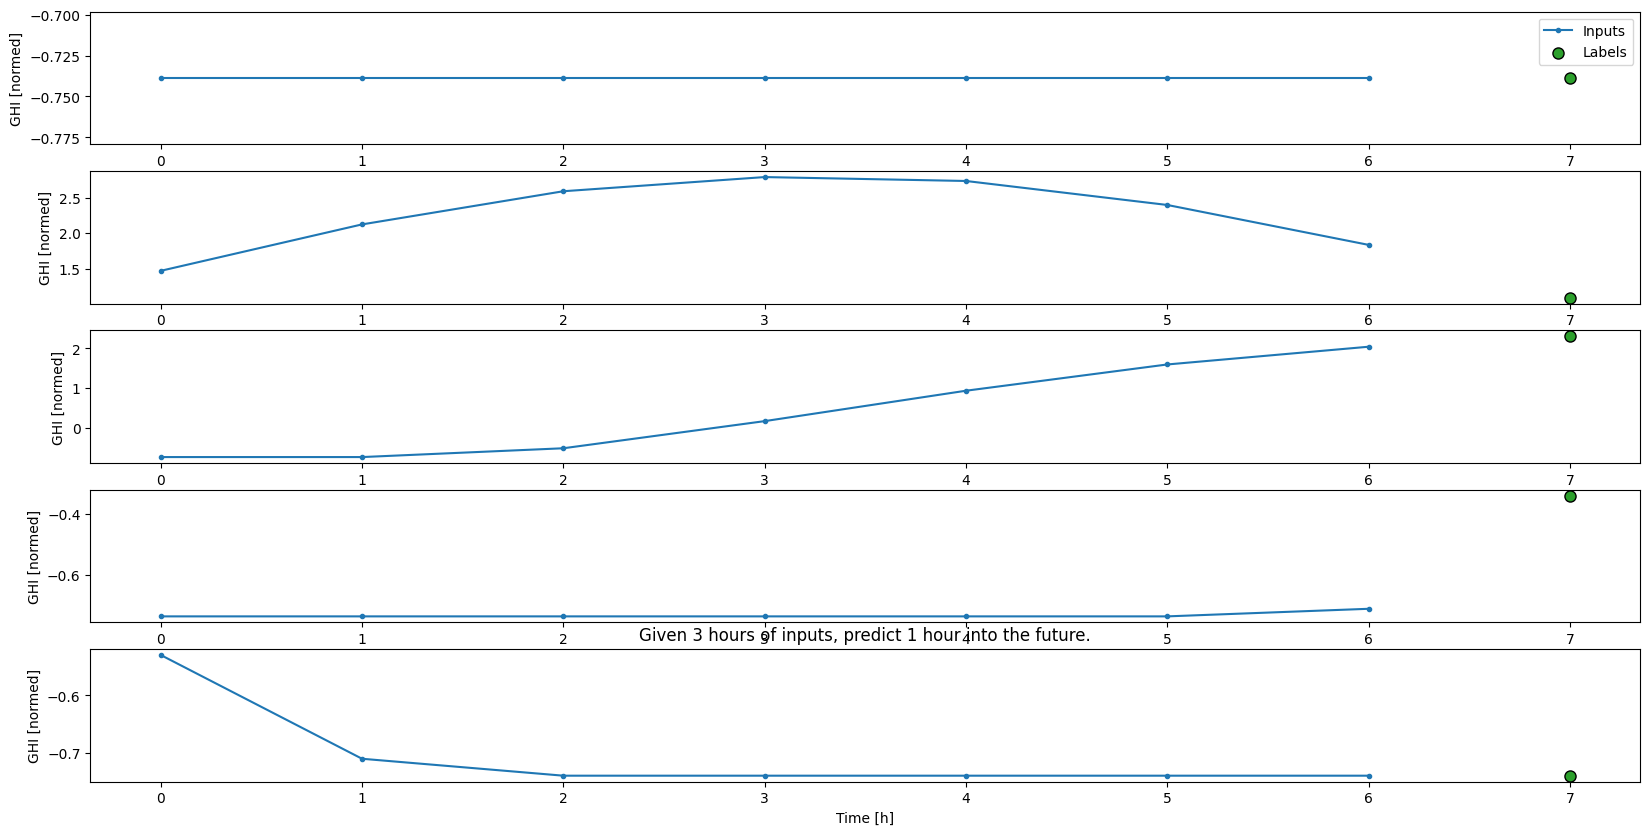

In [193]:
conv_window.plot()
plt.title("Given 7 hours of inputs, predict 1 hour into the future.")

In [194]:
#trained by dense model
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 7, 10)
Output shape: (32, 1, 1)


In [195]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

146/146 [==============================] - 0s 970us/step - loss: 0.1153 - mean_squared_error: 0.0467


tf.Tensor(
[-0.7387617 -0.7387617 -0.7387617 -0.7387617 -0.7387617 -0.7387617
 -0.7387617], shape=(7,), dtype=float32)
tf.Tensor([-0.7299316], shape=(1,), dtype=float32)
tf.Tensor([1.469283  2.1228888 2.5897985 2.789417  2.7343264 2.3966415 1.8348533], shape=(7,), dtype=float32)
tf.Tensor([1.0943469], shape=(1,), dtype=float32)
tf.Tensor(
[-0.7387617  -0.7387617  -0.51703906  0.16581227  0.9312995   1.5923867
  2.0388925 ], shape=(7,), dtype=float32)
tf.Tensor([2.269654], shape=(1,), dtype=float32)
tf.Tensor(
[-0.7387617 -0.7387617 -0.7387617 -0.7387617 -0.7387617 -0.7387617
 -0.7135969], shape=(7,), dtype=float32)
tf.Tensor([-0.3381936], shape=(1,), dtype=float32)
tf.Tensor(
[-0.53030163 -0.7095161  -0.7387617  -0.7387617  -0.7387617  -0.7387617
 -0.7387617 ], shape=(7,), dtype=float32)
tf.Tensor([-0.74170315], shape=(1,), dtype=float32)


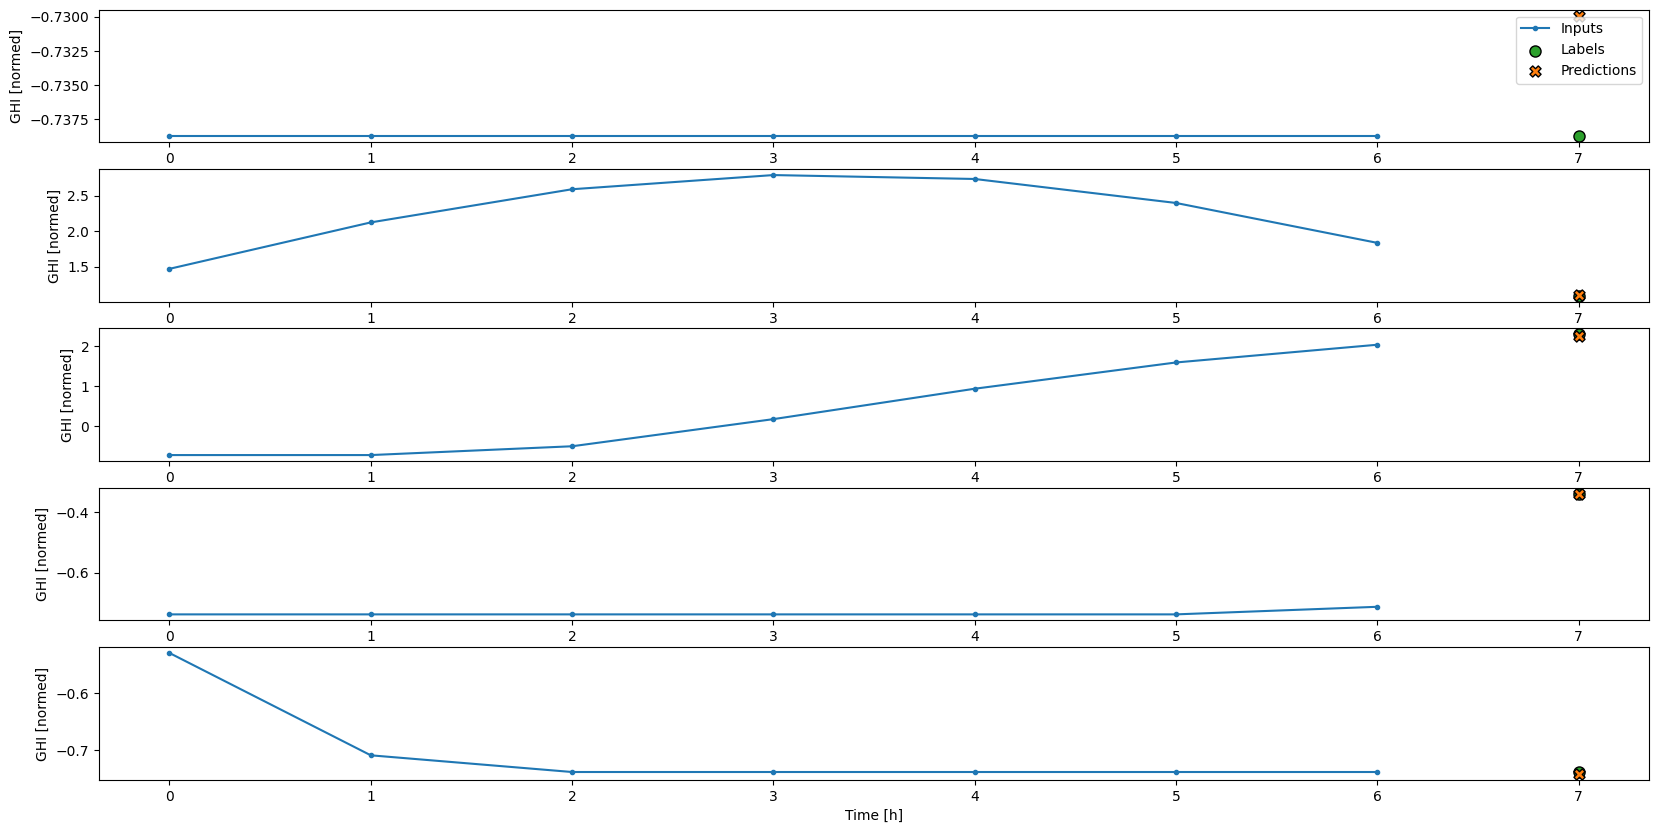

In [196]:
conv_window.plot(multi_step_dense)

In [197]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 72, 10)

ValueError:Exception encountered when calling layer 'sequential_8' (type Sequential).

Input 0 of layer "dense_15" is incompatible with the layer: expected axis -1 of input shape to have value 70, but received input with shape (32, 720)

Call arguments received by layer 'sequential_8' (type Sequential):
  • inputs=tf.Tensor(shape=(32, 72, 10), dtype=float32)
  • training=None
  • mask=None


In [198]:
#CNN
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 7, 10)
Output shape: (32, 1, 1)


In [199]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

146/146 [==============================] - 0s 735us/step - loss: 0.1051 - mean_squared_error: 0.0456


In [200]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 72, 10)
Labels shape: (32, 72, 1)
Output shape: (32, 66, 1)


In [224]:
LABEL_WIDTH = 72
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['GHI'])

wide_conv_window

Total window size: 79
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77]
Label indices: [ 7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54
 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78]
Label column name(s): ['GHI']

Wide conv window
Input shape: (32, 78, 10)
Labels shape: (32, 72, 1)
Output shape: (32, 72, 1)
tf.Tensor(
[-0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7329806
 -0.5847121  -0.29021543  0.10222004  0.6810114   1.2074326   1.3373376
  0.93742067  0.86124605  0.24096672 -0.09977882 -0.4381439  -0.68639165
 -0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7387617
 -0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7316204
 -0.54968536 -0.1932968   0.1763543   0.49907637  0.81975806  1.0322989
  1.1792072   1.0714065   0.83948183  0.37869322 -0.18615542 -0.6398027
 -0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7387617
 -0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7220985
 -0.2640304   0.5307025   1.3043513   1.9392534   2.326928    2.4554727
  2.1987233   1.8450553   1.2295369   0.42052126 -0.2847744  -0.662247
 -0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7387617
 -0.7387617  -0.7387617  -0.73

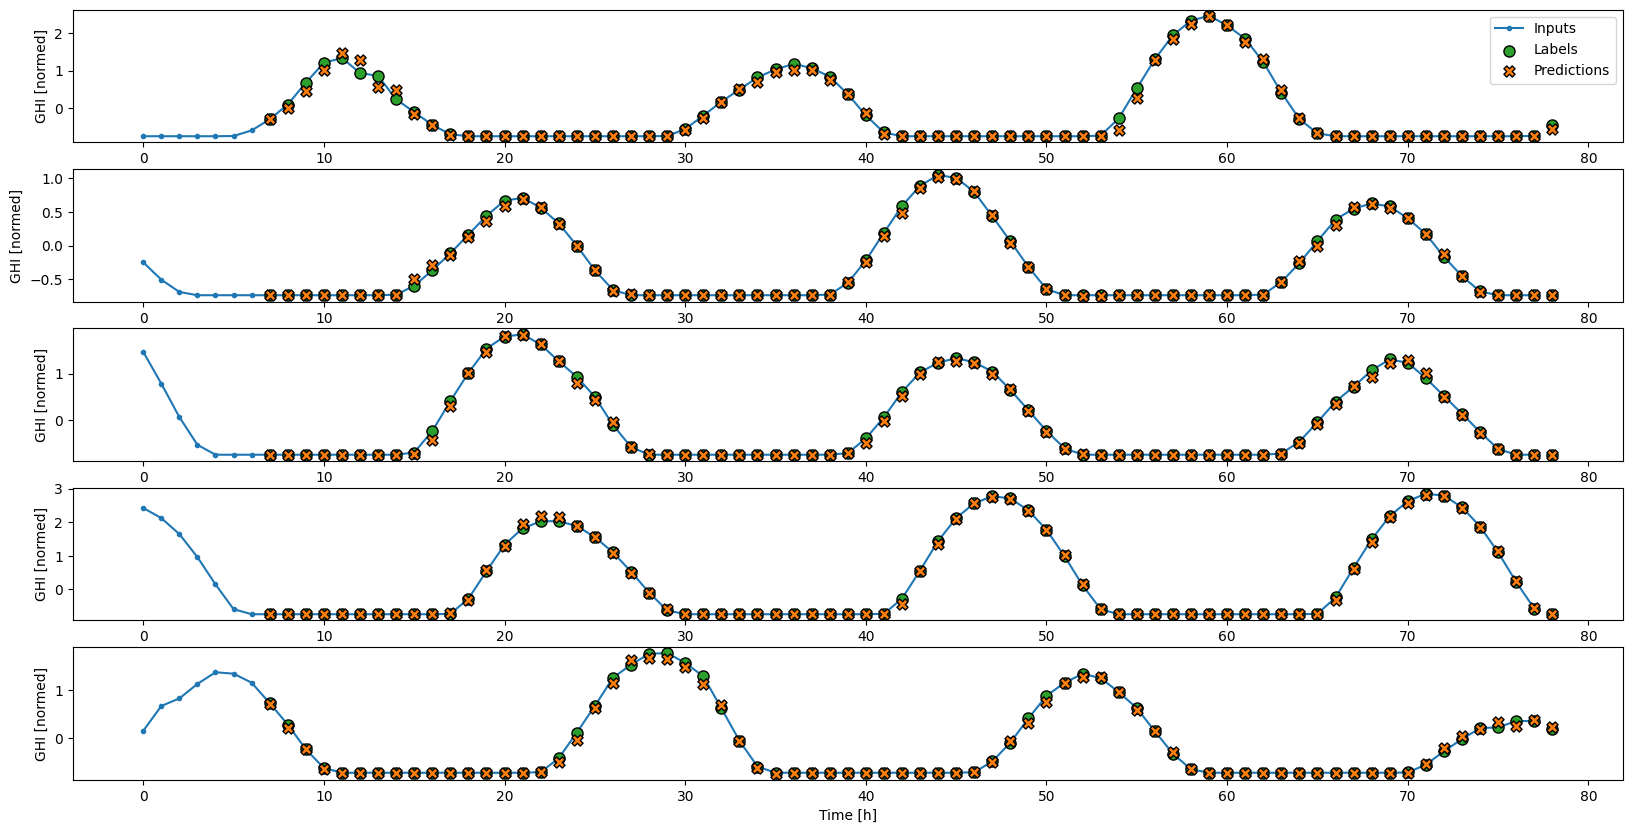

In [225]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)
wide_conv_window.plot(conv_model)

In [233]:
#RNN
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(48, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', wide_conv_window.example[0].shape)
print('Output shape:', lstm_model(wide_conv_window.example[0]).shape)


Input shape: (32, 78, 10)
Output shape: (32, 78, 1)


In [234]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/200
674/674 [==============================] - 10s 12ms/step - loss: 0.3877 - mean_squared_error: 0.3532 - val_loss: 0.3018 - val_mean_squared_error: 0.2095
Epoch 2/200
674/674 [==============================] - 8s 12ms/step - loss: 0.1643 - mean_squared_error: 0.0804 - val_loss: 0.2024 - val_mean_squared_error: 0.1016
Epoch 3/200
674/674 [==============================] - 8s 12ms/step - loss: 0.1094 - mean_squared_error: 0.0402 - val_loss: 0.1578 - val_mean_squared_error: 0.0729
Epoch 4/200
674/674 [==============================] - 8s 12ms/step - loss: 0.0821 - mean_squared_error: 0.0257 - val_loss: 0.1352 - val_mean_squared_error: 0.0605
Epoch 5/200
674/674 [==============================] - 8s 12ms/step - loss: 0.0686 - mean_squared_error: 0.0201 - val_loss: 0.1237 - val_mean_squared_error: 0.0542
Epoch 6/200
674/674 [==============================] - 8s 12ms/step - loss: 0.0604 - mean_squared_error: 0.0171 - val_loss: 0.1161 - val_mean_squared_error: 0.0501
Epoch 7/200
674

tf.Tensor(
[-0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7329806
 -0.5847121  -0.29021543  0.10222004  0.6810114   1.2074326   1.3373376
  0.93742067  0.86124605  0.24096672 -0.09977882 -0.4381439  -0.68639165
 -0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7387617
 -0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7316204
 -0.54968536 -0.1932968   0.1763543   0.49907637  0.81975806  1.0322989
  1.1792072   1.0714065   0.83948183  0.37869322 -0.18615542 -0.6398027
 -0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7387617
 -0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7220985
 -0.2640304   0.5307025   1.3043513   1.9392534   2.326928    2.4554727
  2.1987233   1.8450553   1.2295369   0.42052126 -0.2847744  -0.662247
 -0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7387617
 -0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7387617  -0.7282197 ], shape=(78,), dtype=float32)


ValueError: x and y must be the same size

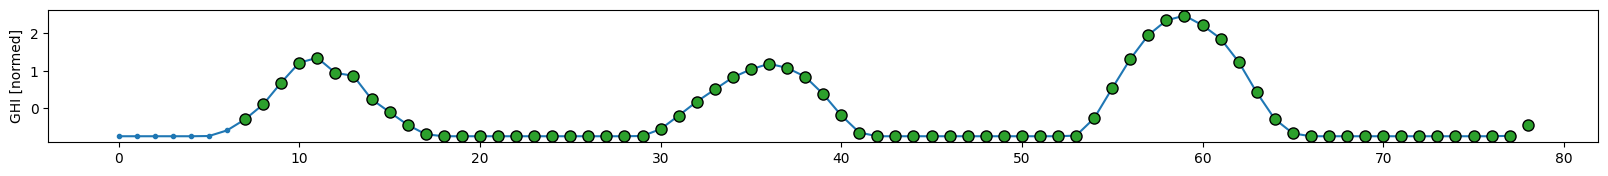

In [228]:
wide_conv_window.plot(lstm_model)

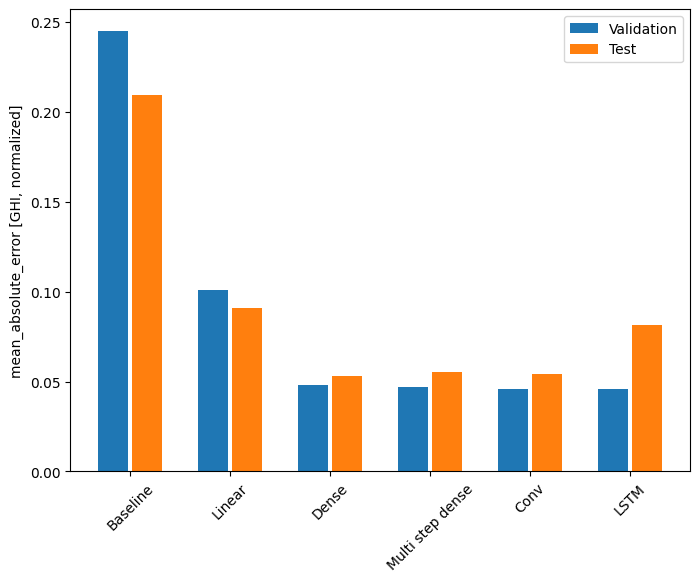

In [210]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_squared_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [GHI, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [207]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.2097
Linear      : 0.0912
Dense       : 0.0529
Multi step dense: 0.0556
Conv        : 0.0540
LSTM        : 0.0814


In [208]:
print(lstm_model.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 72, 10), dtype=tf.float32, name='lstm_input'), name='lstm_input', description="created by layer 'lstm_input'")


In [209]:
a = 0.5*cursor_std 
print(a)

temp          1.581243
WinDir       61.453889
GHI         147.030536
Wind          1.240609
Vx            1.482417
Vy            1.292605
Day cos       0.353577
Day sin       0.353546
Year cos      0.351296
Year sin      0.349980
dtype: float64
